## ETK Filtering

In [1]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
statistics = Statistics.Statistics(simulator, N_e=100)

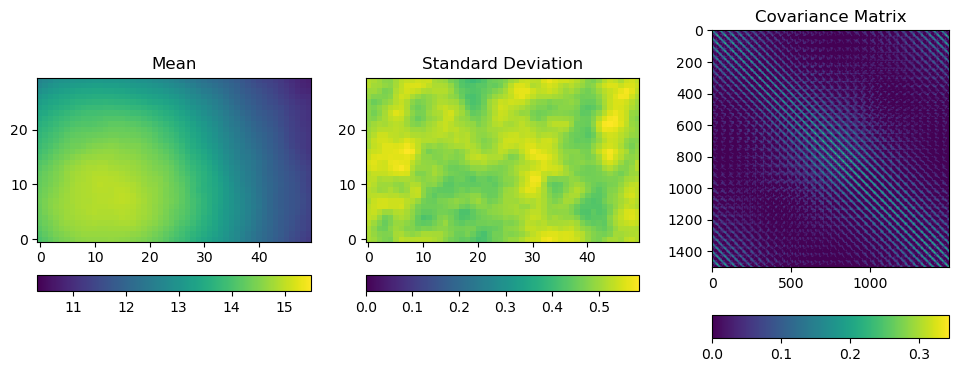

In [4]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [5]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

In [6]:
statistics.propagate(25)

In [7]:
import numpy as np

In [8]:
# Preparation!

In [27]:
# Innovations
d = np.reshape(observation.obses[0], (observation.N_y,1)) - observation.H @ statistics.ensemble.ensemble

In [10]:
S = np.linalg.inv( observation.H @ simulator.Q @ observation.H.T + observation.R)

In [11]:
phis = np.zeros(statistics.ensemble.N_e)
for e in range(statistics.ensemble.N_e):
    phis[e] = d[:,e] @ S @ d[:,e]

In [28]:
cs = np.max(phis) - phis

In [13]:
# Per ensemble member!

In [29]:
eta = np.random.standard_normal(grid.N_x)

In [30]:
z = np.random.standard_normal(grid.N_x)
xi = z - eta * (z@eta)/(eta@eta)

In [31]:
eta @ xi

-3.197442310920451e-14

In [18]:
# Compute alpha

In [19]:
from scipy.special import gammainc

In [20]:
fun = lambda alpha, m, x: gammainc(m, alpha*x)/gammainc(m, x)

In [21]:
from scipy.optimize import fsolve

In [22]:
alpha0 = 0.5

In [24]:
alpha = fsolve( lambda alpha: fun(alpha, grid.N_x/2, eta@eta/2) - np.exp(-cs[0]/2), alpha0)
alpha

array([0.49544339])

In [32]:
# Update one ensemble member 

In [39]:
member_proposal = statistics.ensemble.ensemble[:,0] + simulator.Q @ observation.H.T @ S @ d[:,e]

In [43]:
Pinv = np.linalg.inv( np.linalg.inv(simulator.Q) + observation.H.T @ np.linalg.inv(observation.R) @ observation.H )


In [58]:
from scipy.linalg import sqrtm 

sqrtPinv = np.real(sqrtm(Pinv))

In [59]:
member_update = member_proposal + 1 * sqrtPinv @ eta + np.sqrt(alpha) * sqrtPinv @ xi

In [60]:
member_update

array([11.58424371, 11.65431349, 11.99203969, ..., 11.89104187,
       11.82577032, 11.63954753])